In [6]:
#영화리뷰 감상분석 도전하기
#데이터준비와 확인

import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [7]:
#데이터로더 구성
#실습 때 다루었던 IMDB 데이터셋은 텍스트를 가공하여 imdb.data_loader() 메서드를 호출하면 
#숫자 인덱스로 변환된 텍스트와 word_to_index 딕셔너리까지 친절하게 제공합니다


#그러나 이번에 다루게 될 nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있습니다. 
#이것을 읽어서 imdb.data_loader()와 동일하게 동작하는 자신만의 data_loader를 만들어 보는 것으로 시작합니다. 
#data_loader 안에서는 다음을 수행해야 합니다.

#데이터의 중복 제거
#NaN 결측치 제거
#한국어 토크나이저로 토큰화
#불용어(Stopwords) 제거
#사전word_to_index 구성
#텍스트 스트링을 사전 인덱스 스트링으로 변환
#X_train, y_train, X_test, y_test, word_to_index 리턴

from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [14]:
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown

In [15]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [16]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

KeyError: 2

In [17]:
# 3. 모델 구성을 위한 데이터 분석 및 가공

In [18]:
#데이터셋 내 문장 길이 분포
#적절한 최대 문장 길이 지정

total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [19]:
#keras.preprocessing.sequnce.pad_sequnences을 활용한 패딩 추가

import tensorflow as tf

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index['<PAD>'],
                                                        padding='post',
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index['<PAD>'],
                                                       padding='post',
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


In [ ]:
# 4. 모델 구성 및 validation set 구성

#모델은 3가지 이상 다양하게 구성하여 실험해 보세요.

In [ ]:
# validation set으로 73091 쓰고 훈련용으로 73091 사용할 예정 

In [20]:
#RNN 모델

vocab_size = 73091  # 어휘 사전의 크기입니다
word_vector_dim = 10  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model_rnn = tf.keras.Sequential()
model_rnn.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_rnn.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model_rnn.add(tf.keras.layers.Dense(8, activation='relu'))
model_rnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_rnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 10)          730910    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 608       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 731,599
Trainable params: 731,599
Non-trainable params: 0
_________________________________________________________________


In [21]:
#CNN 모델

vocab_size = 73091  # 어휘 사전의 크기입니다
word_vector_dim = 10   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model_cnn = tf.keras.Sequential()
model_cnn.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_cnn.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_cnn.add(tf.keras.layers.MaxPooling1D(5))
model_cnn.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_cnn.add(tf.keras.layers.GlobalMaxPooling1D())
model_cnn.add(tf.keras.layers.Dense(8, activation='relu'))
model_cnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 10)          730910    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1136      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [22]:
#globalmaxpooling1d() 레이어 하나만 사용

vocab_size = 73091  # 어휘 사전의 크기입니다
word_vector_dim = 10   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model_gmp1d = tf.keras.Sequential()
model_gmp1d.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_gmp1d.add(tf.keras.layers.GlobalMaxPooling1D())
model_gmp1d.add(tf.keras.layers.Dense(8, activation='relu'))
model_gmp1d.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_gmp1d.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 10)          730910    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 10)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 88        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 731,007
Trainable params: 731,007
Non-trainable params: 0
_________________________________________________________________


In [23]:
# 모델 훈련전 데이터셋에서 검증셋 분리

# validation set 73091건 분리
X_val = X_train[:73091]   
y_val = y_train[:73091]

# validation set을 제외한 나머지 73091건
partial_X_train = X_train[73091:]  
partial_y_train = y_train[73091:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(73091, 41)
(73091,)


In [ ]:
# 5. 모델 훈련 개시

In [24]:
#rnn모델 훈련
model_rnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5   

history = model_rnn.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/5
143/143 [==============================] - 5s 11ms/step - loss: 0.6561 - accuracy: 0.6049 - val_loss: 0.5096 - val_accuracy: 0.7934
Epoch 2/5
143/143 [==============================] - 1s 7ms/step - loss: 0.4169 - accuracy: 0.8279 - val_loss: 0.3858 - val_accuracy: 0.8335
Epoch 3/5
143/143 [==============================] - 1s 7ms/step - loss: 0.3381 - accuracy: 0.8616 - val_loss: 0.3676 - val_accuracy: 0.8406
Epoch 4/5
143/143 [==============================] - 1s 7ms/step - loss: 0.3115 - accuracy: 0.8745 - val_loss: 0.3710 - val_accuracy: 0.8405
Epoch 5/5
143/143 [==============================] - 1s 7ms/step - loss: 0.2974 - accuracy: 0.8813 - val_loss: 0.3691 - val_accuracy: 0.8399


In [25]:
#cnn모델 훈련
model_cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  #

history = model_cnn.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/5
143/143 [==============================] - 13s 8ms/step - loss: 0.5525 - accuracy: 0.7243 - val_loss: 0.3884 - val_accuracy: 0.8312
Epoch 2/5
143/143 [==============================] - 1s 6ms/step - loss: 0.3532 - accuracy: 0.8496 - val_loss: 0.3629 - val_accuracy: 0.8429
Epoch 3/5
143/143 [==============================] - 1s 6ms/step - loss: 0.3131 - accuracy: 0.8693 - val_loss: 0.3625 - val_accuracy: 0.8432
Epoch 4/5
143/143 [==============================] - 1s 6ms/step - loss: 0.2871 - accuracy: 0.8829 - val_loss: 0.3658 - val_accuracy: 0.8425
Epoch 5/5
143/143 [==============================] - 1s 6ms/step - loss: 0.2659 - accuracy: 0.8930 - val_loss: 0.3752 - val_accuracy: 0.8416


In [26]:
##globalmaxpooling1d() 레이어 하나만 사용한 모델 훈련
model_gmp1d.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5 

history = model_gmp1d.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/5
143/143 [==============================] - 1s 5ms/step - loss: 0.6679 - accuracy: 0.7003 - val_loss: 0.6099 - val_accuracy: 0.7808
Epoch 2/5
143/143 [==============================] - 1s 4ms/step - loss: 0.5152 - accuracy: 0.8112 - val_loss: 0.4422 - val_accuracy: 0.8162
Epoch 3/5
143/143 [==============================] - 1s 5ms/step - loss: 0.3922 - accuracy: 0.8397 - val_loss: 0.3885 - val_accuracy: 0.8279
Epoch 4/5
143/143 [==============================] - 1s 4ms/step - loss: 0.3451 - accuracy: 0.8559 - val_loss: 0.3763 - val_accuracy: 0.8325
Epoch 5/5
143/143 [==============================] - 1s 4ms/step - loss: 0.3185 - accuracy: 0.8680 - val_loss: 0.3733 - val_accuracy: 0.8349


In [38]:
#학습이 끝난 모델을 테스트셋으로 평가

#rnn
print("RNN")
results_rnn = model_rnn.evaluate(X_test,  y_test, verbose=2)
print(results_rnn)

RNN
1537/1537 - 3s - loss: 0.3757 - accuracy: 0.8382
[0.37572216987609863, 0.8382325768470764]


In [39]:
#cnn
print("CNN")
results_cnn = model_cnn.evaluate(X_test,  y_test, verbose=2)
print(results_cnn)

CNN
1537/1537 - 2s - loss: 0.3817 - accuracy: 0.8383
[0.38169556856155396, 0.8382529616355896]


In [40]:
#globalmaxpooling1d() 레이어 하나만 사용한 모델
print("globalmaxpooling1d() 레이어 하나만 사용한 모델")
results_gmp1d = model_gmp1d.evaluate(X_test,  y_test, verbose=2)
print(results_gmp1d)

globalmaxpooling1d() 레이어 하나만 사용한 모델
1537/1537 - 2s - loss: 0.3769 - accuracy: 0.8327
[0.3769429922103882, 0.8327400088310242]


In [ ]:
#6. Loss, Accuracy 그래프 시각화

In [35]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


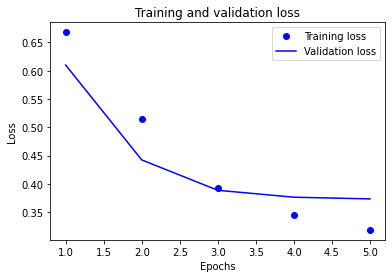

In [36]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
#loss 그래프 분석:
#epoch 3을 기준으로 tloss와 vloss의 차이가 벌어지면서 vloss가 tloss보다 더 높아졌으니까 
#epoch는 3으로 설정하는게 더 적절해보임

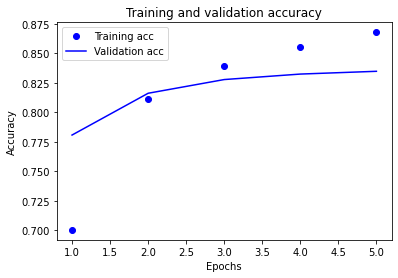

In [37]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
#accuray 그래프 분석:
#loss 그래프와 같은 이유로 epoch 5보단 3이 더 적절해보임
#accuray 그래프만 보면 epoch 2가 더 적절해보이지만 loss 그래프도 고려해서 종합적으로 생각해보면 최종족으로 epoch 3이 적절해보임

In [ ]:
# 7. 학습된 Embedding 레이어 분석

In [45]:
embedding_layer = model_rnn.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(73091, 10)


In [51]:
import os


# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-3, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 3개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model_rnn.get_weights()[0]
for i in range(3, 9999):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [57]:
#gensim에서 제공하는 패키지를 이용해, 
#위에 남긴 임베딩 파라미터를 읽어서 word vector로 활용

from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

ValueError: could not broadcast input array from shape (10,) into shape (300,)

In [ ]:
# 8. 한국어 Word2Vec 임베딩 활용하여 성능 개선